In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

In [16]:
# Load the dataset
df = pd.read_csv(r"C:\Users\Chabri Ganesh\spotify_dataset.csv", on_bad_lines = 'skip')
df.head()

,user_id,"""artistname""","""trackname""","""playlistname"""
0,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello,(The Angels Wanna Wear My) Red Shoes,HARD ROCK 2010
1,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello & The Attractions,"(What's So Funny 'Bout) Peace, Love And Unders...",HARD ROCK 2010
2,9cc0cfd4d7d7885102480dd99e7a90d6,Tiffany Page,7 Years Too Late,HARD ROCK 2010
3,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello & The Attractions,Accidents Will Happen,HARD ROCK 2010
4,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello,Alison,HARD ROCK 2010


In [19]:
# Drop duplicates and handle missing values
df.drop_duplicates(inplace=True)
df.columns = df.columns.str.strip().str.replace('"', '')
df = df.dropna(subset=['artistname', 'trackname', 'playlistname'])

In [22]:
# Creating Combined Features for Each Song
df['combined_features'] = df['trackname'] + ' ' + df['artistname'] + ' ' + df.get('genre', '')

In [23]:
# Vectorize Tracks for Similarity Calculation
cv = CountVectorizer(stop_words='english')
track_matrix = cv.fit_transform(df['combined_features'])

In [26]:
# Define Playlist Generation Function
def recommend_tracks(seed_track, n=20):
    if seed_track not in df['trackname'].values:
        print("Seed track not found in the dataset.")
        return []
    idx = df[df['trackname'] == seed_track].index[0]
    cosine_scores = cosine_similarity(track_matrix[idx], track_matrix).flatten()
    # Sort scores and get indices of top recommendations excluding the seed
    similar_indices = np.argsort(cosine_scores)[::-1][1:n+1]
    recommended = df.iloc[similar_indices][['trackname', 'artistname', 'playlistname']]
    return recommended

In [27]:
# Example Usage
rec_playlist = recommend_tracks('Shape of You')
print(rec_playlist)

                    trackname       artistname  \
9547522            Bright Red  Laurie Anderson   
6694158            Bright Red  Laurie Anderson   
12441633        Here With You  Laurie Anderson   
6694198         Here with You  Laurie Anderson   
6694197         Here With You  Laurie Anderson   
8293168         Here With You  Laurie Anderson   
6694147   Beautiful Red Dress  Laurie Anderson   
11743951  Beautiful Red Dress  Laurie Anderson   
11328764  Beautiful Red Dress  Laurie Anderson   
11328483  Beautiful Red Dress  Laurie Anderson   
808298         Red Map - Live  Laurie Anderson   
6694258        Red Map - Live  Laurie Anderson   
6694110        Red Map - Live  Laurie Anderson   
2918959   Beautiful Red Dress  Laurie Anderson   
6694254              Progress  Laurie Anderson   
808212                Falling  Laurie Anderson   
10949707              Falling  Laurie Anderson   
6108705            O Superman  Laurie Anderson   
1384335            O Superman  Laurie Anderson   


In [29]:
# Try with multiple seed tracks
for seed in ['Here With You', 'Bright Red', 'O Superman']:
    print(f"\nRecommendations for: {seed}\n")
    print(recommend_tracks(seed, n=10).to_string(index=False))


Recommendations for: Here With You

trackname      artistname                    playlistname
     Mary Scissor Sisters                      00's Tunes
     Mary Scissor Sisters            Definitely not greek
     Mary Scissor Sisters                           Music
     Mary Scissor Sisters Pale Shelter (Original Version)
     Mary Scissor Sisters                         Starred
     Mary Scissor Sisters                         Starred
     Mary Scissor Sisters                         Starred
     Mary Scissor Sisters                         Adriaan
     Mary Scissor Sisters                 Night night mix
     Mary Scissor Sisters                          Liquid

Recommendations for: Bright Red

trackname artistname                playlistname
  Friends    Whodini                   oldemusic
  Friends    Whodini                     Starred
  Friends    Whodini         50 Hip Hop Classics
  Friends    Whodini                  80's Music
  Friends    Whodini                     Hip-H

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer
# TF-IDF Vectorization
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['combined_features'])

In [33]:
def recommend_tracks_tfidf(seed_track, n=20):
    if seed_track not in df['trackname'].values:
        print("Seed track not found in the dataset.")
        return []
    idx = df[df['trackname'] == seed_track].index[0]
    cosine_scores = cosine_similarity(tfidf_matrix[idx], tfidf_matrix).flatten()
    similar_indices = np.argsort(cosine_scores)[::-1][1:n+1]  # Exclude seed itself
    recommended = df.iloc[similar_indices][['trackname', 'artistname', 'playlistname']]
    return recommended

In [34]:
rec_playlist_tfidf = recommend_tracks_tfidf('Here With You', n=10)
print(rec_playlist_tfidf)

         trackname       artistname               playlistname
210572        Mary  Scissor Sisters             Birthday feels
8904306       Mary  Scissor Sisters  omg do you remember that?
10864475      Mary  Scissor Sisters              Suicide songs
7661354       Mary  Scissor Sisters                    Chilled
9530192       Mary  Scissor Sisters                      Music
6354824       Mary  Scissor Sisters                      PARTY
12460325      Mary  Scissor Sisters               Dusty Sunday
10701163      Mary  Scissor Sisters     Scissor Sisters. Hits.
8780668       Mary  Scissor Sisters            Nats playlist 1
3949877       Mary  Scissor Sisters                    Starred


In [35]:
def recommend_tracks_diverse(seed_track, n=20):
    recs = recommend_tracks_tfidf(seed_track, n*3)  # get more for filtering
    recs = recs.drop_duplicates(subset=['artistname'])  # unique artists
    return recs.head(n)

In [36]:
print(recommend_tracks_diverse('Bright Red', n=10))

        trackname artistname     playlistname
8928035   Friends    Whodini  Pop Lock Music 


In [37]:
recommendations = recommend_tracks_tfidf('O Superman', n=10)
recommendations.to_csv('recommendations.csv', index=False)
print("Recommendations saved to recommendations.csv")

Recommendations saved to recommendations.csv


In [38]:
import ipywidgets as widgets
from IPython.display import display
seed_input = widgets.Text(
    value='Here With You',
    description='Seed Track:',
    disabled=False
)
num_input = widgets.IntSlider(
    value=10,
    min=1,
    max=20,
    step=1,
    description='Num Songs:',
    disabled=False
)
def display_recommendations(seed, n):
    recs = recommend_tracks_tfidf(seed, n)
    print(recs)
widgets.interactive(display_recommendations, seed=seed_input, n=num_input)

interactive(children=(Text(value='Here With You', description='Seed Track:'), IntSlider(value=10, description=…

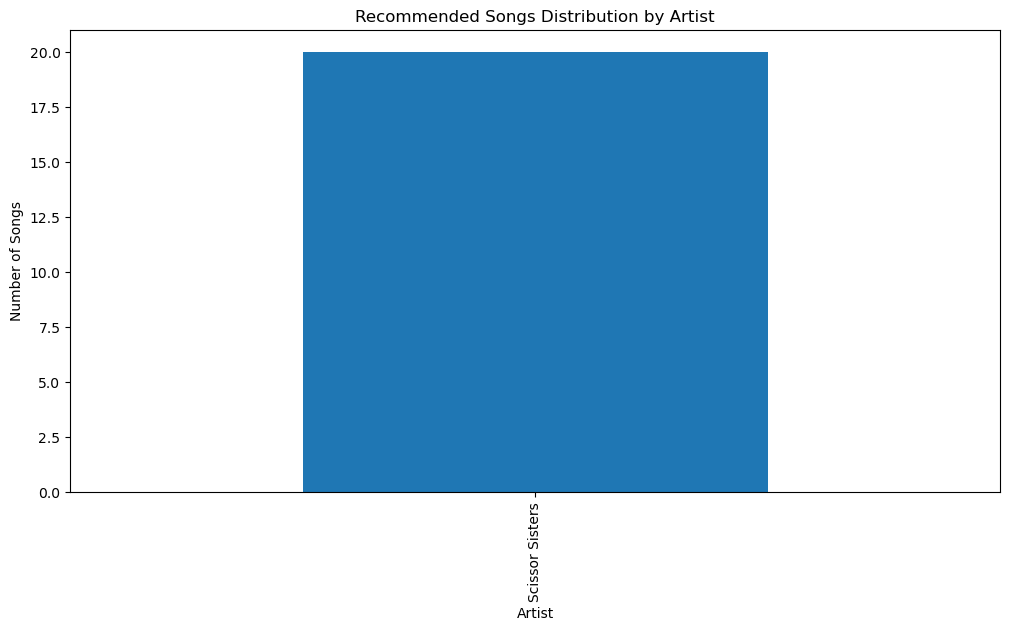

In [39]:
import matplotlib.pyplot as plt
recs = recommend_tracks_tfidf('Here With You', n=20)
plt.figure(figsize=(12,6))
recs['artistname'].value_counts().plot(kind='bar')
plt.title("Recommended Songs Distribution by Artist")
plt.xlabel("Artist")
plt.ylabel("Number of Songs")
plt.show()

In [40]:
def recommend_tracks_with_popularity(seed_track, n=20, alpha=0.7):
    if seed_track not in df['trackname'].values:
        print("Seed track not found in dataset.")
        return []
    idx = df[df['trackname'] == seed_track].index[0]
    sim_scores = cosine_similarity(tfidf_matrix[idx], tfidf_matrix).flatten()    
    # Normalize similarity and popularity (example popularity column: 'popularity')
    if 'popularity' in df.columns:
        pop_scores = df['popularity'].fillna(0)
        pop_scores_norm = (pop_scores - pop_scores.min()) / (pop_scores.max() - pop_scores.min())
    else:
        pop_scores_norm = np.zeros_like(sim_scores)    
    # Weighted score
    combined_score = alpha * sim_scores + (1 - alpha) * pop_scores_norm
    recommended_indices = np.argsort(combined_score)[::-1][1:n+1]
    return df.iloc[recommended_indices][['trackname', 'artistname', 'playlistname', 'popularity'] if 'popularity' in df.columns else ['trackname', 'artistname', 'playlistname']]